In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #разделение выборки
from sklearn import preprocessing #предобработка
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [3]:
churn_data = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/c903ecd0b0c995c44213d620ab6ae94d/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/churn.zip')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Строим модели отдельно для каждой страны.  
Выделяем данные, относящиеся только к Германии.

In [4]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [5]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [6]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Создадим новые признаки

BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;  
TenureByAge — отношение времени пользования банком к возрасту клиента;  
CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.  

In [7]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

In [8]:
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


Разделим набор данных на матрицу наблюдений и столбец правильных ответов

In [9]:
X = churn_data.drop('Exited', axis=1)
y = churn_data['Exited']

Нормализуем

In [10]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [11]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Классы не сбалансированны  
В тестовые данные могут попасть только лояльные клиенты и наоборот

Нужно сделать так, чтобы в трейн и тест выборках было одинаковое соотношение лояльных и ушедших клиентов. 

Такое разбиение называется стратифицированым

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


In [13]:
print('Train :\n', y_train.value_counts(normalize=True))
print('\n')
print('Test :\n', y_test.value_counts(normalize=True))

Train :
 0    0.675704
1    0.324296
Name: Exited, dtype: float64


Test :
 0    0.675159
1    0.324841
Name: Exited, dtype: float64


In [14]:
from sklearn import ensemble

#Создаём объект класса RandomForestClassifier
rf_clf_full = ensemble.RandomForestClassifier(
    max_depth=8, #максимальная глубина дерева
    criterion='entropy', #критерий эффективности
    min_samples_split=10,
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_full.fit(X_train, y_train)
 
y_train_predict = rf_clf_full.predict(X_train)
print(f'Train f1_score {metrics.f1_score(y_train, y_train_predict)}')
y_test_predict = rf_clf_full.predict(X_test)
print(f'Test f1_score {metrics.f1_score(y_test, y_test_predict)}')

print(f'Test accuracy {metrics.accuracy_score(y_train, y_train_predict)}')
print(f'Test accuracy {metrics.accuracy_score(y_test, y_test_predict)}')

print(f'Test precision_score {metrics.precision_score(y_train, y_train_predict)}')
print(f'Test precision_score {metrics.precision_score(y_test, y_test_predict)}')

print(f'Test accuracy {metrics.classification_report(y_train, y_train_predict)}')
print(f'Test accuracy {metrics.classification_report(y_test, y_test_predict)}')

Train f1_score 0.7530288909599254
Test f1_score 0.659400544959128
Test accuracy 0.8591174906964381
Test accuracy 0.8009554140127388
Test precision_score 0.8725701943844493
Test precision_score 0.7423312883435583
Test accuracy               precision    recall  f1-score   support

           0       0.85      0.95      0.90      1271
           1       0.87      0.66      0.75       610

    accuracy                           0.86      1881
   macro avg       0.86      0.81      0.83      1881
weighted avg       0.86      0.86      0.85      1881

Test accuracy               precision    recall  f1-score   support

           0       0.82      0.90      0.86       424
           1       0.74      0.59      0.66       204

    accuracy                           0.80       628
   macro avg       0.78      0.75      0.76       628
weighted avg       0.80      0.80      0.79       628



In [15]:
from sklearn import tree
#Создаём объект класса RandomForestClassifier
dt_full = tree.DecisionTreeClassifier(
    max_depth=8, #максимальная глубина дерева
    criterion='entropy', #критерий эффективности
    min_samples_split=10,
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
dt_full.fit(X_train, y_train)

y_train_predict = dt_full.predict(X_train)
print(f'Train f1_score {metrics.f1_score(y_train, y_train_predict)}')
y_test_predict = dt_full.predict(X_test)
print(f'Test f1_score {metrics.f1_score(y_test, y_test_predict)}')

print(f'Test accuracy {metrics.accuracy_score(y_train, y_train_predict)}')
print(f'Test accuracy {metrics.accuracy_score(y_test, y_test_predict)}')

print(f'Test precision_score {metrics.precision_score(y_train, y_train_predict)}')
print(f'Test precision_score {metrics.precision_score(y_test, y_test_predict)}')

print(f'Test accuracy {metrics.classification_report(y_train, y_train_predict)}')
print(f'Test accuracy {metrics.classification_report(y_test, y_test_predict)}')

Train f1_score 0.7435669920141971
Test f1_score 0.631578947368421
Test accuracy 0.8463583200425305
Test accuracy 0.7770700636942676
Test precision_score 0.8104448742746615
Test precision_score 0.6818181818181818
Test accuracy               precision    recall  f1-score   support

           0       0.86      0.92      0.89      1271
           1       0.81      0.69      0.74       610

    accuracy                           0.85      1881
   macro avg       0.84      0.80      0.82      1881
weighted avg       0.84      0.85      0.84      1881

Test accuracy               precision    recall  f1-score   support

           0       0.81      0.87      0.84       424
           1       0.68      0.59      0.63       204

    accuracy                           0.78       628
   macro avg       0.75      0.73      0.74       628
weighted avg       0.77      0.78      0.77       628



Соотношения одинаковы

Определяем метрику, на которую будем ориентироваться.  
F1-мера. Пытаемся минимизировать ложные срабатывания, при этом необходимо сохранить как можно больше клиентов.

Обучаем модель логистической регрессии на тренировочных данных.

In [28]:
log_reg = linear_model.LogisticRegression(
    solver='sag',#алгоритм минимизации функции потерь
    random_state=42
)
log_reg.fit(X_train, y_train)
y_train_predict = log_reg.predict(X_train)

#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_predict)))

F1 score: 0.49


Тестовые данные

In [29]:
y_test_predict = log_reg.predict(X_test)

#Рассчитываем F1-меру
print('F1 score: {:.3f}'.format(metrics.f1_score(y_test, y_test_predict)))

F1 score: 0.471


Генерируем полиномиальные признаки 3 степени

In [30]:
from sklearn.preprocessing import PolynomialFeatures

In [31]:
poly = PolynomialFeatures(
    3,
    include_bias=False
    )
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
print(f'X_train_poly.shape: {X_train_poly.shape}')
print(f'X_test_poly.shape: {X_test_poly.shape}')

X_train_poly.shape: (1881, 454)
X_test_poly.shape: (628, 454)


Обучаем модель на полиномиальных признаках

In [40]:
log_reg_poly = linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000
)
log_reg_poly.fit(X_train_poly, y_train)
y_train_poly_predict = log_reg_poly.predict(X_train_poly)
print('F1 train score: {:.3f}'.format(metrics.f1_score(y_train, y_train_poly_predict)))

y_test_poly_predict = log_reg_poly.predict(X_test_poly)
print('F1 test score: {:.3f}'.format(metrics.f1_score(y_test, y_test_poly_predict)))

F1 train score: 0.655
F1 test score: 0.637


Подбираем значение порога вероятности, используя модель, обученную на полиномиальных признаках

In [51]:
y_test_proba_pred = log_reg_poly.predict_proba(X_test_poly)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)

thresholds = np.arange(0.1, 1, 0.05)

f1_scores = []
for threshold in thresholds:
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

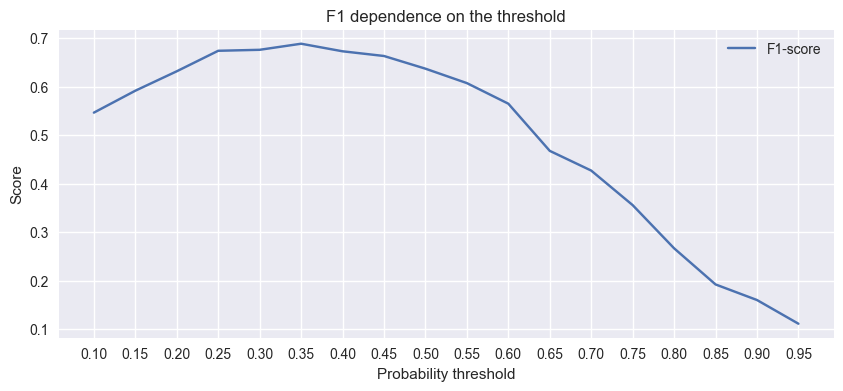

In [52]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
 
#Даём графику название и подписываем оси
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

Делаем предсказание классов с оптимальным порогом вероятности

In [53]:
threshold_opt = 0.35

y_test_proba_pred = log_reg_poly.predict_proba(X_test_poly)[:, 1]
y_test_proba_pred = pd.Series(y_test_proba_pred)
y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold_opt else 0)

print('F1 test score: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))


F1 test score: 0.689
